In [1]:
import numpy as np
import emcee
import pandas as pd
import matplotlib.pyplot as plt
import corner
%matplotlib notebook

To understand the effects of telescope aperture (or limiting mag) on one's ability to recover the time of explosion (or better, the time of first light for a young SN), we construct a simple generative model to simulate the flux from the SN. 

$$ \begin{align} f_\mathrm{SN}(t) & = 0, & \mathrm{when}\; t \le t_\mathrm{exp} \\ & \propto (t-t_\mathrm{exp})^{\alpha}, & \mathrm{when}\; t > t_\mathrm{exp} \end{align}. $$

Where $t$ is time, $t_\mathrm{exp}$ is the time of SN explosion, and $\alpha$ is the power-law index of the initial rise.

To account for the noise in the telescope system, a systematic contribution is added to the SN flux, where the magnitude of the systematic term is related to the limiting magnitude of the telescope. For example, when we adopt:
$$ m = 25 - 2.5\log(\mathrm{counts}),$$
for a $m = 20\,\mathrm{mag}$ $5\sigma$ limit, the counts = 100 and therefore `sigma_sys` = 20.

Using this generative model, we can incorporate the effects of a detection limit via the `sigma_sys` variable. In particular, smaller aperture telescopes will have larger values of sigma_sys as follows:

 

| $m_\mathrm{lim}$ | counts | `sigma_sys` |
|   ----           |   ---- |     ----    |
|   21.5           |   25.1 |     5.02    |
|   21.0           |   39.8 |     7.96    |
|   20.0           |  100.0 |    20.00    |
|   19.0           |  251.2 |    50.23    |
|   18.0           |  631.0 |   126.19    |
|   17.0           | 1584.9 |   316.98    |
|   16.0           | 3981.1 |   796.21    |

In [47]:
def gen_data(times, baseline=0, t_exp=0, alpha=2, 
             amplitude=25, sigma_sys=5):
    '''
    Generate a simple SN Ia-like light curve
    
    Parameters
    ----------
    
    times : array-like
        The times at which the simulated data should be generated.
        Times are in units of days.
    
    baseline : float, optional (default=0)
        The baseline value for the flux of the transient in the 
        telescope system.
    
    t_exp : float, optional (default=0)
        The time of explosion for the SN.
    
    alpha : float, optional (default=2)
        Power-law index for the initial rise of the SN.
    
    amplitude : float, optional (default=25)
        Normalizing amplitude for rise of the SN, the default value
        is determined by assuming an alpha=2 increase in flux, 
        m_peak = 15 mag, and a 20 d rise time for the SN.
    
    sigma_sys : float, optional (default=5)
        The systematic noise present in the light curves due to 
        the telescope system.
    
    Returns
    -------
    cnts : array-like, shape=shape(times)
        The counts corresponding to the SN flux, after taking into 
        account the noise associated with the detector
    
    cnts_unc : array-like, shape=shape(times)
        Uncertainty in the number of counts from the SN
    '''
    
    cnts = np.zeros_like(times)
    cnts_unc = np.zeros_like(times)

    pre_explosion = np.logical_not(times > t_exp)
    cnts[pre_explosion] = np.random.normal(baseline, sigma_sys, size=sum(pre_explosion))
    cnts_unc[pre_explosion] = np.ones_like(times)[pre_explosion]*sigma_sys

    sn_flux = amplitude*(times[~pre_explosion] - t_exp)**alpha
    sn_with_random_noise = sn_flux + np.random.normal(np.zeros_like(sn_flux), np.sqrt(sn_flux))
    sn_with_random_plus_sys = sn_with_random_noise + np.random.normal(baseline, sigma_sys, size=len(sn_flux))

    # total uncertainty = systematic + Poisson
    sn_uncertainties = np.hypot(np.sqrt(sn_with_random_noise), sigma_sys)

    cnts[~pre_explosion] = sn_with_random_plus_sys
    cnts_unc[~pre_explosion] = sn_uncertainties

    return cnts, cnts_unc
    

Example light curves for a telescope with $m_\mathrm{lim} \approx 20\,\mathrm{mag}$ and $m_\mathrm{lim} \approx 17\,\mathrm{mag}$ are shown below. It's clear that the inferred parameters, and $t_0$ in particular are going to be very different for the two telescopes. 

<IPython.core.display.Javascript object>


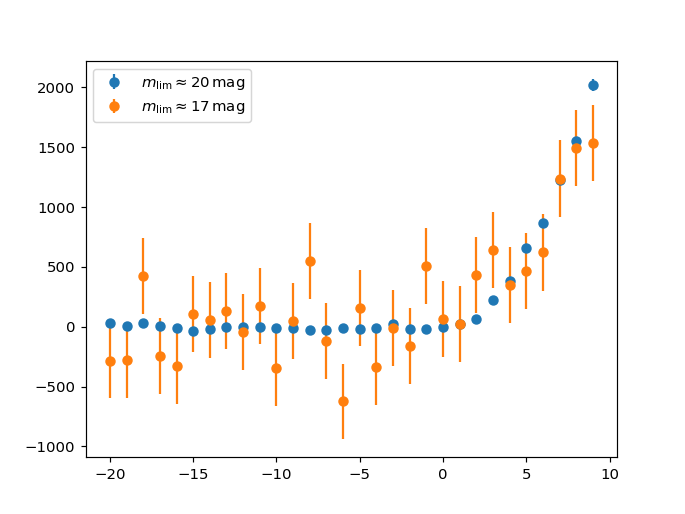

In [51]:
for label, sigma_sys in zip([r"$m_\mathrm{lim} \approx 20\,\mathrm{mag}$", 
                             r"$m_\mathrm{lim} \approx 17\,\mathrm{mag}$"], 
                            [20, 317]):
    times = np.arange(-20,10, dtype=float)
    cnts, cnts_unc = gen_data(times, sigma_sys=sigma_sys)
    plt.errorbar(times, cnts, cnts_unc, fmt='o', 
                 label=label)
    plt.legend()            

We now wish to model the simulated light curves using our new Bayesian framework.

In [52]:
#Define the log likelihood
def lnlikelihood(theta, f, t, f_err):
    a, lnb, t_0, alpha, sig_0 = theta
    b = np.exp(lnb)

    pre_exp = np.logical_not(t > t_0)
    model = np.empty_like(f)
    model[pre_exp] = a
    model[~pre_exp] = a + (b*((t[~pre_exp] - t_0)**alpha))
    ln_l = np.sum(np.log(1. / np.sqrt(2*np.pi * (sig_0**2 + f_err**2))) - ((f - model)**2 / (2 * (sig_0**2 + f_err**2))))
    return ln_l

#Define priors on parameters  
def lnprior(theta):
    a, lnb, t_0, alpha, sig_0 = theta
    if(-100 < t_0 < -10 and 0 < alpha < 100 and 0 < sig_0 < 100 and -100 < a < 100 and  -100 < lnb < 10):
        return 0.0
    return -np.inf
   
def posterior(theta, f, t, f_err):
    prior = lnprior(theta)
    lnl = lnlikelihood(theta, f, t, f_err)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(prior):
        return -np.inf
    return lnl + prior 